## X-Ray Abnormality Detection with CNNs

> **Antonopoulos Ilias** ( *p3352004* ) <br />
> **Ndoja Silva** ( *p3352017* ) <br />
> **MSc in Data Science, AUEB**

## Table of Contents

- [Data Loading](#Data-Loading)
 * [Create a tensorflow input pipeline for the training data](#Create-a-tensorflow-input-pipeline-for-the-training-data)
 * [Create a tensorflow input pipeline for the testing data](#Create-a-tensorflow-input-pipeline-for-the-testing-data)
- [Baseline Performance](#Baseline-Performance)
 * [Random Classification](#Random-Classification)
 * [CNN architecture with sensible defaults](#CNN-architecture-with-sensible-defaults)
 * [Only on XR_SHOULDER study type](#Only-on-XR_SHOULDER-study-type)

In [1]:
import gc
import os
import pathlib
import random
import re
from glob import glob
from PIL import Image
from typing import Iterable

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
from matplotlib import image
from sklearn.metrics import cohen_kappa_score, confusion_matrix


pd.set_option("max_colwidth", None)
plt.style.use("dark_background")

In [2]:
print(tf.__version__)

2.8.0


In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))

Num GPUs Available:  1


2022-03-26 21:38:56.126010: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-26 21:38:56.152883: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-26 21:38:56.153057: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [4]:
gpus = tf.config.experimental.list_physical_devices("GPU")

try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
except IndexError:
    print("Cannot memory-restrict the GPU, if no GPU exists in system. Ignore...")
    pass

In [5]:
SEED = 99910123

os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)
np.random.seed(SEED)

### Data Loading

In [6]:
DATASET_DIR = "../data/MURA-v1.1/"

In [7]:
def inspect_df(df: pd.DataFrame, n: int = 5) -> pd.DataFrame:
    """Helper method to easily inspect DataFrames."""

    print(f"shape: {df.shape}")

    return df.head(n)

In [8]:
random.choices(glob(os.path.join(DATASET_DIR, "*", "*", "*", "*", "*.png")), k=10)

['../data/MURA-v1.1/train/XR_WRIST/patient08092/study1_negative/image1.png',
 '../data/MURA-v1.1/train/XR_FINGER/patient01064/study1_positive/image1.png',
 '../data/MURA-v1.1/valid/XR_ELBOW/patient11831/study1_positive/image1.png',
 '../data/MURA-v1.1/train/XR_SHOULDER/patient00442/study1_positive/image1.png',
 '../data/MURA-v1.1/train/XR_ELBOW/patient06289/study1_negative/image3.png',
 '../data/MURA-v1.1/train/XR_WRIST/patient08562/study1_negative/image2.png',
 '../data/MURA-v1.1/train/XR_FINGER/patient04280/study1_negative/image3.png',
 '../data/MURA-v1.1/train/XR_WRIST/patient07018/study1_positive/image1.png',
 '../data/MURA-v1.1/train/XR_ELBOW/patient06000/study1_negative/image1.png',
 '../data/MURA-v1.1/train/XR_SHOULDER/patient00497/study2_negative/image4.png']

So, the data structure is the following:

```

└─train {data subset}
│   └───XR_ELBOW {study type}
│       │  └───patient00011 {patient}
│       │         └───study1_negative {study with label}
│       │               └───image1.png {view}
│       │               └───image2.png 
│       │               └───image3.png 
                        └───...
   ...
   

└─valid {data subset}
│   └───XR_HUMERUS {study type}
│       │  └───patient11216 {patient}
│       │         └───study1_negative {study with label}
│       │               └───image1.png {view}
│       │               └───image2.png 
                        └───...
```

In [9]:
image_count = len(list(pathlib.Path(DATASET_DIR).glob("*/*/*/*/*.png")))

print(f"Total PNG images found in dir <{DATASET_DIR}>: {image_count}")

Total PNG images found in dir <../data/MURA-v1.1/>: 40009


We will start by creating a tabular form of the training data (with no actual image files), in order to quickly analyze them. A proper data loader (of the actual image files) will be implemented after that, in a tensorflow-friendly manner.

In [10]:
train_image_paths = pd.read_csv(
    os.path.join(DATASET_DIR, "train_image_paths.csv"),
    names=["image_path"],
    header=None,
    index_col=False,
)

inspect_df(train_image_paths)

shape: (36808, 1)


,image_path
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image1.png
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image2.png
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image3.png
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image1.png
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image2.png


In [11]:
train_image_paths["image_path"] = train_image_paths["image_path"].map(
    lambda x: os.path.join("../data/", x)
)
train_image_paths["study_type"] = train_image_paths["image_path"].map(
    lambda x: x.split("/")[4]
)
train_image_paths["patient"] = train_image_paths["image_path"].map(
    lambda x: x.split("/")[5]
)
train_image_paths["study"] = train_image_paths["image_path"].map(
    lambda x: x.split("/")[6]
)
train_image_paths["study_path"] = train_image_paths["image_path"].map(
    lambda x: re.sub(r"image\d+.png", "", x)
)

In [12]:
inspect_df(train_image_paths)

shape: (36808, 5)


,image_path,study_type,patient,study,study_path
0,../data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image1.png,XR_SHOULDER,patient00001,study1_positive,../data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/
1,../data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image2.png,XR_SHOULDER,patient00001,study1_positive,../data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/
2,../data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image3.png,XR_SHOULDER,patient00001,study1_positive,../data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/
3,../data/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image1.png,XR_SHOULDER,patient00002,study1_positive,../data/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/
4,../data/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image2.png,XR_SHOULDER,patient00002,study1_positive,../data/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/


In [13]:
train_labeled_studies = pd.read_csv(
    os.path.join(DATASET_DIR, "train_labeled_studies.csv"),
    names=["study_path", "label"],
    header=None,
    index_col=False,
)

inspect_df(train_labeled_studies)

shape: (13457, 2)


,study_path,label
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/,1
1,MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/,1
2,MURA-v1.1/train/XR_SHOULDER/patient00003/study1_positive/,1
3,MURA-v1.1/train/XR_SHOULDER/patient00004/study1_positive/,1
4,MURA-v1.1/train/XR_SHOULDER/patient00005/study1_positive/,1


In [14]:
train_labeled_studies["study_path"] = train_labeled_studies["study_path"].map(
    lambda x: os.path.join("../data/", x)
)
train_labeled_studies["label"] = train_labeled_studies["label"].map(str)

In [15]:
inspect_df(train_labeled_studies)

shape: (13457, 2)


,study_path,label
0,../data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/,1
1,../data/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/,1
2,../data/MURA-v1.1/train/XR_SHOULDER/patient00003/study1_positive/,1
3,../data/MURA-v1.1/train/XR_SHOULDER/patient00004/study1_positive/,1
4,../data/MURA-v1.1/train/XR_SHOULDER/patient00005/study1_positive/,1


In [16]:
ref_trainset = pd.merge(
    train_image_paths, train_labeled_studies, how="inner", on="study_path"
)

inspect_df(ref_trainset)

shape: (36808, 6)


,image_path,study_type,patient,study,study_path,label
0,../data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image1.png,XR_SHOULDER,patient00001,study1_positive,../data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/,1
1,../data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image2.png,XR_SHOULDER,patient00001,study1_positive,../data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/,1
2,../data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image3.png,XR_SHOULDER,patient00001,study1_positive,../data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/,1
3,../data/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image1.png,XR_SHOULDER,patient00002,study1_positive,../data/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/,1
4,../data/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image2.png,XR_SHOULDER,patient00002,study1_positive,../data/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/,1


#### Create a tensorflow input pipeline for the training data

In [17]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224

In [18]:
training = tf.keras.preprocessing.image.ImageDataGenerator(
    #     rotation_range=30,
    #     brightness_range=None,
    #     shear_range=0.2,
    #     zoom_range=0.2,
    #     horizontal_flip=True,
    #     fill_mode="constant",
    #     cval=0.0,
    rescale=1.0 / 255,
    validation_split=0.2,
)

In [19]:
trainset = training.flow_from_dataframe(
    dataframe=ref_trainset,
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=32,
    seed=SEED,
    shuffle=True,
    subset="training",
)

Found 29447 validated image filenames belonging to 2 classes.


In [20]:
validationset = training.flow_from_dataframe(
    dataframe=ref_trainset,
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=32,
    seed=SEED,
    subset="validation",
)

Found 7361 validated image filenames belonging to 2 classes.


#### Create a tensorflow input pipeline for the testing data

In [21]:
test_image_paths = pd.read_csv(
    os.path.join(DATASET_DIR, "valid_image_paths.csv"),
    names=["image_path"],
    header=None,
    index_col=False,
)

In [22]:
test_image_paths["image_path"] = test_image_paths["image_path"].map(
    lambda x: os.path.join("../data/", x)
)
test_image_paths["study_type"] = test_image_paths["image_path"].map(
    lambda x: x.split("/")[4]
)
test_image_paths["patient"] = test_image_paths["image_path"].map(
    lambda x: x.split("/")[5]
)
test_image_paths["study"] = test_image_paths["image_path"].map(
    lambda x: x.split("/")[6]
)
test_image_paths["study_path"] = test_image_paths["image_path"].map(
    lambda x: re.sub(r"image\d+.png", "", x)
)

In [23]:
test_labeled_studies = pd.read_csv(
    os.path.join(DATASET_DIR, "valid_labeled_studies.csv"),
    names=["study_path", "label"],
    header=None,
    index_col=False,
)

In [24]:
test_labeled_studies["study_path"] = test_labeled_studies["study_path"].map(
    lambda x: os.path.join("../data/", x)
)
test_labeled_studies["label"] = test_labeled_studies["label"].map(str)

In [25]:
ref_testset = pd.merge(
    test_image_paths, test_labeled_studies, how="inner", on="study_path"
)

inspect_df(ref_testset)

shape: (3197, 6)


,image_path,study_type,patient,study,study_path,label
0,../data/MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image1.png,XR_WRIST,patient11185,study1_positive,../data/MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/,1
1,../data/MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image2.png,XR_WRIST,patient11185,study1_positive,../data/MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/,1
2,../data/MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image3.png,XR_WRIST,patient11185,study1_positive,../data/MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/,1
3,../data/MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image4.png,XR_WRIST,patient11185,study1_positive,../data/MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/,1
4,../data/MURA-v1.1/valid/XR_WRIST/patient11186/study1_positive/image1.png,XR_WRIST,patient11186,study1_positive,../data/MURA-v1.1/valid/XR_WRIST/patient11186/study1_positive/,1


In [26]:
testing = tf.keras.preprocessing.image.ImageDataGenerator(
    #     rotation_range=30,
    #     brightness_range=None,
    #     shear_range=0.2,
    #     zoom_range=0.2,
    #     horizontal_flip=True,
    #     fill_mode="constant",
    #     cval=0.0,
    rescale=1.0
    / 255,
)

In [27]:
testset = testing.flow_from_dataframe(
    dataframe=ref_testset,
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=32,
    seed=SEED,
)

Found 3197 validated image filenames belonging to 2 classes.


### Baseline Performance

#### Random Classification

In [28]:
class RandomClassifier(object):
    """Random classifier - predicts whether an image is normal or abnormal at random."""

    def predict(self, image_path: str) -> float:

        return random.random()

In [29]:
temp_testset = ref_testset.copy()

temp_testset["label"] = temp_testset["label"].map(int)

In [30]:
model = RandomClassifier()

temp_testset["prediction"] = temp_testset["image_path"].map(model.predict)

In [31]:
cohen_kappa_score(
    temp_testset["label"].values,
    np.vectorize(lambda x: 1 if x > 0.5 else 0)(temp_testset["prediction"].values),
)

0.0049013669964691475

We now have to aggregate all the predictions - in a meaningful way - at the study level.

We will assume that if the majority of the images of a given study are classified as abnormal, then the study will be classified as abnormal as well (and vice versa).

In [32]:
def study_oriented_transformation(dataset: pd.DataFrame) -> Iterable:

    for study, group in dataset.groupby("study_path"):

        study_label = group["label"].values.take(0)
        study_prediction = 1 if group["prediction"].mean() > 0.5 else 0

        yield study, study_label, study_prediction

In [33]:
temp_testset = pd.DataFrame(
    [*study_oriented_transformation(temp_testset)],
    columns=["study", "label", "prediction"],
)

In [34]:
cohen_kappa_score(temp_testset["label"].values, temp_testset["prediction"].values)

-0.02330674545107736

In [35]:
del temp_testset
del model

#### CNN architecture with sensible defaults

In [36]:
def clean_up(model_):
    tf.keras.backend.clear_session()
    del model_
    gc.collect()

In [37]:
# the tfa.metrics.F1Score (https://www.tensorflow.org/addons/api_docs/python/tfa/metrics/F1Score)
# requires some reshaping that is inconsistent with the other metrics we like to track
# so we will define it from scratch


class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name="f1_score", **kwargs):
        super().__init__(name=name, **kwargs)
        self.f1 = self.add_weight(name="f1", initializer="zeros")
        self.precision_fn = tf.keras.metrics.Precision()
        self.recall_fn = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        p = self.precision_fn(y_true, y_pred)
        r = self.recall_fn(y_true, y_pred)
        self.f1.assign(2 * ((p * r) / (p + r + 1e-10)))

    def result(self):
        return self.f1

    def reset_state(self):
        # we also need to reset the state of the precision and recall objects
        self.precision_fn.reset_state()
        self.recall_fn.reset_state()
        self.f1.assign(0)

In [38]:
METRICS = [
    tf.keras.metrics.TruePositives(name="tp"),
    tf.keras.metrics.FalsePositives(name="fp"),
    tf.keras.metrics.TrueNegatives(name="tn"),
    tf.keras.metrics.FalseNegatives(name="fn"),
    tf.keras.metrics.BinaryAccuracy(name="binary_acc"),
    tf.keras.metrics.Precision(name="precision"),
    tf.keras.metrics.Recall(name="recall"),
    F1Score(name="f1_score"),
    tf.keras.metrics.AUC(name="roc_auc", curve="ROC"),
    tf.keras.metrics.AUC(name="pr_auc", curve="PR"),
    tfa.metrics.CohenKappa(num_classes=2),
]

2022-03-26 21:39:00.752616: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-26 21:39:00.753496: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-26 21:39:00.753688: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-26 21:39:00.753817: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [39]:
def plot_metrics(
    history: tf.keras.callbacks.History,
    metrics: list = ["loss", "cohen_kappa", "precision", "recall"],
) -> None:

    plt.rcParams["figure.figsize"] = (18, 15)

    for n, metric in enumerate(metrics):
        name = metric.replace("_", " ").capitalize()
        plt.subplot(2, 2, n + 1)
        plt.plot(
            history.epoch, history.history[metric], linewidth=1.8, label="training"
        )
        plt.plot(
            history.epoch,
            history.history["val_" + metric],
            linestyle="--",
            linewidth=1.8,
            label="validation",
        )
        plt.xlabel("epoch")
        plt.ylabel(name)
        if metric == "loss":
            plt.ylim([0, plt.ylim()[1]])
        elif metric == "cohen_kappa":
            plt.ylim([-1, 1])
        else:
            plt.ylim([0, 1])

        plt.legend()

In [40]:
def make_cnn_model():
    """Creates a CNN architecture with sensible defaults."""
    model = tf.keras.Sequential(
        [
            tf.keras.layers.Conv2D(
                filters=64,
                kernel_size=(3, 3),
                strides=(1, 1),
                padding="same",
                kernel_regularizer="l2",
                dilation_rate=(1, 1),
                activation="relu",
                input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3),
                name="1st-convolution",
            ),
            tf.keras.layers.MaxPool2D(
                pool_size=(2, 2), strides=(2, 2), padding="same", name="1st-max-pooling"
            ),
            tf.keras.layers.Dropout(
                rate=0.15,
                name="1st-dropout",
            ),
            tf.keras.layers.Conv2D(
                filters=32,
                kernel_size=(3, 3),
                strides=(1, 1),
                padding="same",
                kernel_regularizer="l2",
                dilation_rate=(1, 1),
                activation="relu",
                name="2nd-convolution",
            ),
            tf.keras.layers.MaxPool2D(
                pool_size=(2, 2), strides=(2, 2), padding="same", name="2nd-max-pooling"
            ),
            tf.keras.layers.Dropout(
                rate=0.15,
                name="2nd-dropout",
            ),
            tf.keras.layers.Flatten(name="flatten-layer"),
            tf.keras.layers.Dense(
                units=32,
                kernel_regularizer="l2",
                activation="relu",
                name="dense-layer",
            ),
            tf.keras.layers.Dense(units=1, activation="sigmoid", name="output-layer"),
        ]
    )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=METRICS,
    )

    return model

In [41]:
model = make_cnn_model()

In [42]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 1st-convolution (Conv2D)    (None, 224, 224, 64)      1792      
                                                                 
 1st-max-pooling (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 1st-dropout (Dropout)       (None, 112, 112, 64)      0         
                                                                 
 2nd-convolution (Conv2D)    (None, 112, 112, 32)      18464     
                                                                 
 2nd-max-pooling (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 2nd-dropout (Dropout)       (None, 56, 56, 32)        0

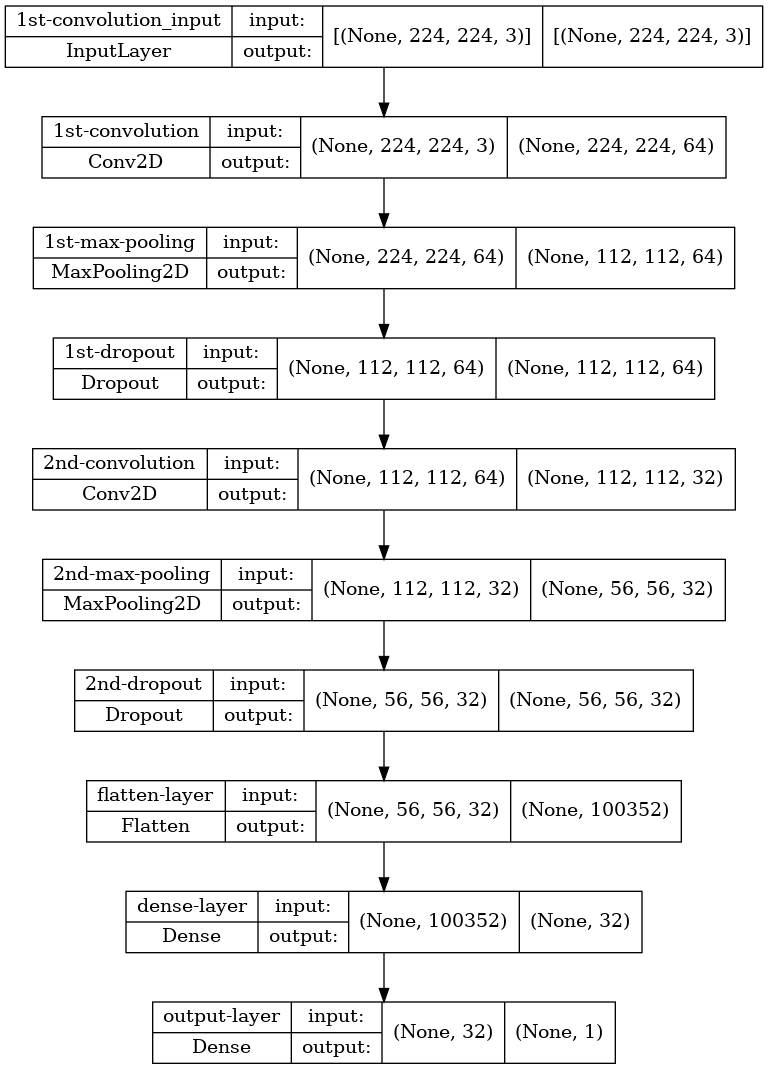

In [43]:
tf.keras.utils.plot_model(
    model,
    to_file="../static/cnn-all-study-types-3231585.png",
    show_shapes=True,
    show_layer_names=True,
)

In [52]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    verbose=1,
    patience=20,
    mode="max",
)

In [53]:
reduce_lr_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.2, verbose=1, patience=5, min_lr=1e-6
)

In [54]:
history = model.fit(
    trainset,
    epochs=100,
    validation_data=validationset,
    callbacks=[early_stopping, reduce_lr_on_plateau],
)

Epoch 1/100


2022-03-26 13:25:50.337242: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8303
2022-03-26 13:25:51.488247: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.02GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-03-26 13:25:51.488288: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.02GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-03-26 13:25:52.760583: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.45GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory

921/921 [==============================] - 164s 172ms/step - loss: 0.8938 - tp: 145.0000 - fp: 152.0000 - tn: 18590.0000 - fn: 10560.0000 - binary_acc: 0.6362 - precision: 0.4882 - recall: 0.0135 - f1_score: 0.0264 - roc_auc: 0.5972 - pr_auc: 0.4361 - cohen_kappa: 0.0069 - val_loss: 0.8601 - val_tp: 18.0000 - val_fp: 2.0000 - val_tn: 3191.0000 - val_fn: 4150.0000 - val_binary_acc: 0.4359 - val_precision: 0.9000 - val_recall: 0.0043 - val_f1_score: 0.0086 - val_roc_auc: 0.5267 - val_pr_auc: 0.5869 - val_cohen_kappa: 0.0032 - lr: 1.0000e-04
Epoch 2/100
921/921 [==============================] - 153s 166ms/step - loss: 0.6903 - tp: 238.0000 - fp: 170.0000 - tn: 18572.0000 - fn: 10467.0000 - binary_acc: 0.6388 - precision: 0.5833 - recall: 0.0222 - f1_score: 0.0428 - roc_auc: 0.6226 - pr_auc: 0.4686 - cohen_kappa: 0.0166 - val_loss: 0.8314 - val_tp: 7.0000 - val_fp: 2.0000 - val_tn: 3191.0000 - val_fn: 4161.0000 - val_binary_acc: 0.4345 - val_precision: 0.7778 - val_recall: 0.0017 - val_f1

921/921 [==============================] - 136s 147ms/step - loss: 0.6240 - tp: 2382.0000 - fp: 1336.0000 - tn: 17406.0000 - fn: 8323.0000 - binary_acc: 0.6720 - precision: 0.6407 - recall: 0.2225 - f1_score: 0.3303 - roc_auc: 0.6787 - pr_auc: 0.5420 - cohen_kappa: 0.1758 - val_loss: 0.8924 - val_tp: 53.0000 - val_fp: 27.0000 - val_tn: 3166.0000 - val_fn: 4115.0000 - val_binary_acc: 0.4373 - val_precision: 0.6625 - val_recall: 0.0127 - val_f1_score: 0.0250 - val_roc_auc: 0.5249 - val_pr_auc: 0.5864 - val_cohen_kappa: 0.0037 - lr: 1.0000e-06
Epoch 29/100
921/921 [==============================] - 136s 147ms/step - loss: 0.6240 - tp: 2413.0000 - fp: 1377.0000 - tn: 17365.0000 - fn: 8292.0000 - binary_acc: 0.6716 - precision: 0.6367 - recall: 0.2254 - f1_score: 0.3329 - roc_auc: 0.6784 - pr_auc: 0.5422 - cohen_kappa: 0.1764 - val_loss: 0.8830 - val_tp: 55.0000 - val_fp: 30.0000 - val_tn: 3163.0000 - val_fn: 4113.0000 - val_binary_acc: 0.4372 - val_precision: 0.6471 - val_recall: 0.0132 - 

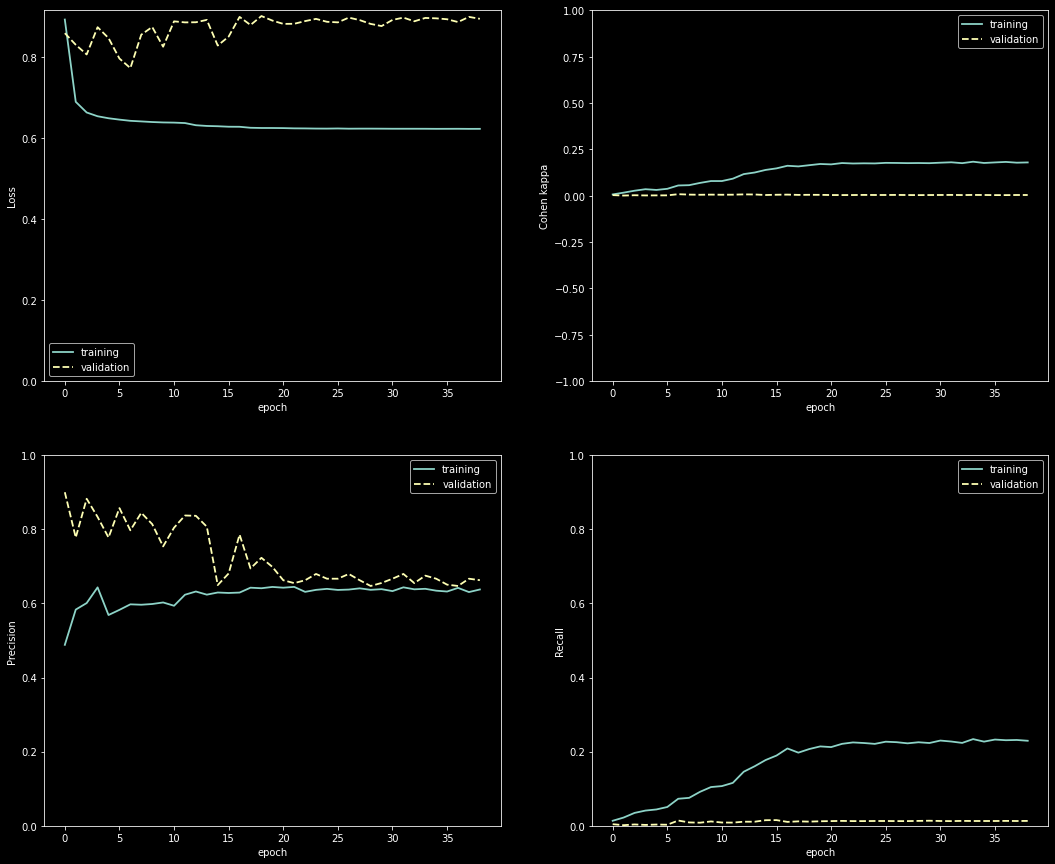

In [91]:
plot_metrics(history)

In [70]:
# get the loss value & metrics values for the model in test mode
evaluation_metrics = model.evaluate(testset, verbose=1)

100/100 [==============================] - 8s 80ms/step - loss: 0.7180 - tp: 234.0000 - fp: 123.0000 - tn: 1544.0000 - fn: 1296.0000 - binary_acc: 0.5561 - precision: 0.6555 - recall: 0.1529 - f1_score: 0.2480 - roc_auc: 0.6189 - pr_auc: 0.6012 - cohen_kappa: 0.0817


In [72]:
loss = evaluation_metrics.pop(0)

print(f"test loss   : {loss}")
for metric, score in zip(METRICS, evaluation_metrics):

    print(f"{metric.name + ' ' * (12 - len(metric.name))}: {score}")

test loss   : 0.718004047870636
tp          : 234.0
fp          : 123.0
tn          : 1544.0
fn          : 1296.0
binary_acc  : 0.5561463832855225
precision   : 0.6554622054100037
recall      : 0.15294118225574493
f1_score    : 0.2480127364397049
roc_auc     : 0.6188948750495911
pr_auc      : 0.6011673212051392
cohen_kappa : 0.08173078298568726


In [137]:
# get predictions for the test dataset
preds = model.predict(testset, verbose=1)

100/100 [==============================] - 8s 78ms/step


In [138]:
temp_testset = ref_testset.copy()

temp_testset["label"] = temp_testset["label"].map(int)

In [139]:
cohen_kappa_score(
    temp_testset["label"].values,
    np.vectorize(lambda x: 1 if x > 0.5 else 0)(preds.ravel()),
)

-0.016632124362819356

In [140]:
temp_testset["prediction"] = preds.ravel()

In [141]:
temp_testset = pd.DataFrame(
    [*study_oriented_transformation(temp_testset)],
    columns=["study", "label", "prediction"],
)

In [143]:
cohen_kappa_score(temp_testset["label"].values, temp_testset["prediction"].values)

-0.011520968316565794

In [144]:
# model naming convention: {architecture}-{study-type}-{num-parameters}.h5
#
# to load model:
# model = tf.keras.models.load_model(
#     '../models/cnn-all-study-types-3231585.h5',
#     custom_objects={'F1Score': F1Score}
# )
model.save("../models/cnn-all-study-types-3231585.h5")

In [158]:
clean_up(model)
del temp_testset

#### Only on XR_SHOULDER study type

In [161]:
trainset = training.flow_from_dataframe(
    dataframe=ref_trainset[ref_trainset["study_type"] == "XR_SHOULDER"],
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=32,
    seed=SEED,
    shuffle=True,
    subset="training",
)

Found 6704 validated image filenames belonging to 2 classes.


In [162]:
validationset = training.flow_from_dataframe(
    dataframe=ref_trainset[ref_trainset["study_type"] == "XR_SHOULDER"],
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=32,
    seed=SEED,
    subset="validation",
)

Found 1675 validated image filenames belonging to 2 classes.


In [163]:
testset = testing.flow_from_dataframe(
    dataframe=ref_testset[ref_testset["study_type"] == "XR_SHOULDER"],
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=32,
    seed=SEED,
)

Found 563 validated image filenames belonging to 2 classes.


In [164]:
model = make_cnn_model()

In [165]:
history = model.fit(
    trainset,
    epochs=100,
    validation_data=validationset,
    callbacks=[early_stopping, reduce_lr_on_plateau],
)

Epoch 1/100
210/210 [==============================] - 34s 153ms/step - loss: 1.2166 - tp: 40.0000 - fp: 71.0000 - tn: 4850.0000 - fn: 3055.0000 - binary_acc: 0.6100 - precision: 0.3604 - recall: 0.0129 - f1_score: 0.0250 - roc_auc: 0.5551 - pr_auc: 0.4223 - cohen_kappa: -0.0018 - val_loss: 1.1372 - val_tp: 6.0000 - val_fp: 0.0000e+00 - val_tn: 72.0000 - val_fn: 1597.0000 - val_binary_acc: 0.0466 - val_precision: 1.0000 - val_recall: 0.0037 - val_f1_score: 0.0075 - val_roc_auc: 0.6261 - val_pr_auc: 0.9745 - val_cohen_kappa: 3.2288e-04 - lr: 1.0000e-04
Epoch 2/100
210/210 [==============================] - 31s 148ms/step - loss: 0.9153 - tp: 70.0000 - fp: 54.0000 - tn: 4085.0000 - fn: 2495.0000 - binary_acc: 0.6198 - precision: 0.5645 - recall: 0.0273 - f1_score: 0.0521 - roc_auc: 0.6129 - pr_auc: 0.4718 - cohen_kappa: 0.0174 - val_loss: 1.1534 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 72.0000 - val_fn: 1603.0000 - val_binary_acc: 0.0430 - val_precision: 0.0000e+00 - val_recal

Epoch 16/100
210/210 [==============================] - 32s 150ms/step - loss: 0.6669 - tp: 688.0000 - fp: 345.0000 - tn: 3794.0000 - fn: 1877.0000 - binary_acc: 0.6686 - precision: 0.6660 - recall: 0.2682 - f1_score: 0.3824 - roc_auc: 0.6951 - pr_auc: 0.5830 - cohen_kappa: 0.2086 - val_loss: 1.0419 - val_tp: 109.0000 - val_fp: 0.0000e+00 - val_tn: 72.0000 - val_fn: 1494.0000 - val_binary_acc: 0.1081 - val_precision: 1.0000 - val_recall: 0.0680 - val_f1_score: 0.1273 - val_roc_auc: 0.7175 - val_pr_auc: 0.9814 - val_cohen_kappa: 0.0062 - lr: 1.0000e-04
Epoch 17/100
210/210 [==============================] - 33s 156ms/step - loss: 0.6636 - tp: 672.0000 - fp: 290.0000 - tn: 3849.0000 - fn: 1893.0000 - binary_acc: 0.6744 - precision: 0.6985 - recall: 0.2620 - f1_score: 0.3811 - roc_auc: 0.6990 - pr_auc: 0.5940 - cohen_kappa: 0.2178 - val_loss: 0.9699 - val_tp: 318.0000 - val_fp: 3.0000 - val_tn: 69.0000 - val_fn: 1285.0000 - val_binary_acc: 0.2310 - val_precision: 0.9907 - val_recall: 0.19

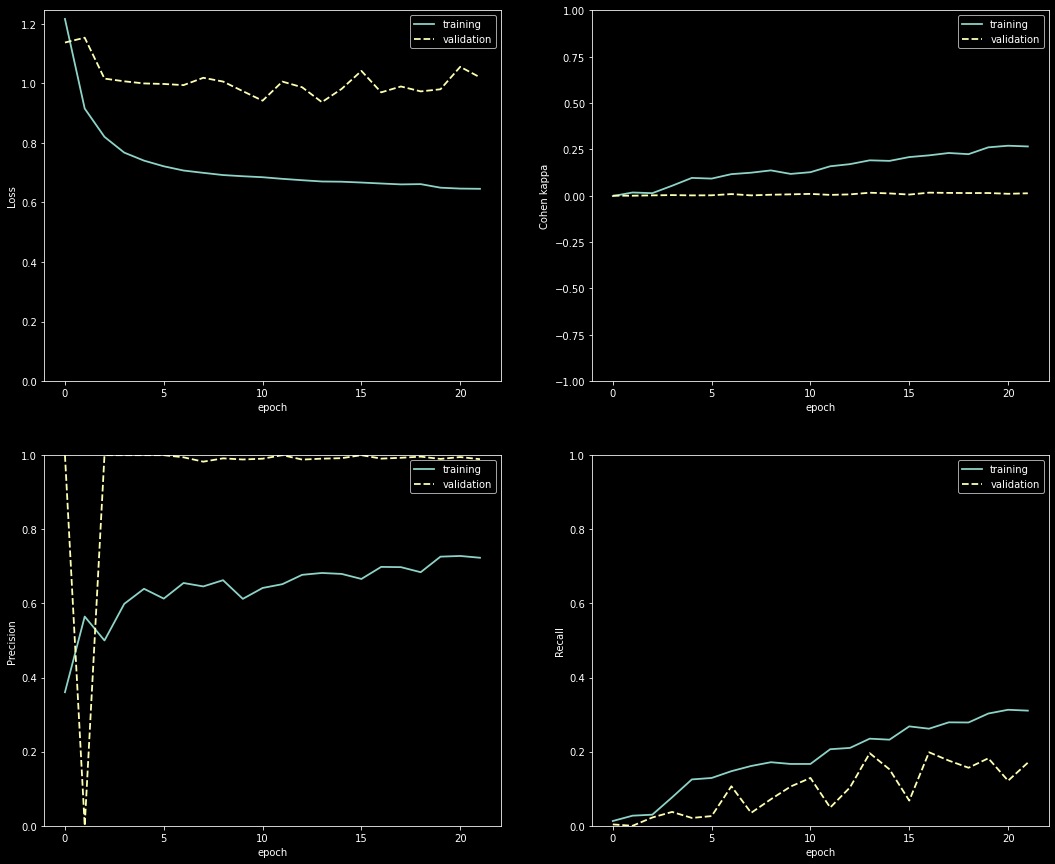

In [166]:
plot_metrics(history)

In [173]:
# get the loss value & metrics values for the model in test mode
evaluation_metrics = model.evaluate(testset, verbose=1)

18/18 [==============================] - 1s 78ms/step - loss: 0.7328 - tp: 54.0000 - fp: 6.0000 - tn: 279.0000 - fn: 224.0000 - binary_acc: 0.5915 - precision: 0.9000 - recall: 0.1942 - f1_score: 0.3195 - roc_auc: 0.6958 - pr_auc: 0.7168 - cohen_kappa: 0.1749


In [174]:
loss = evaluation_metrics.pop(0)

print(f"test loss   : {loss}")
for metric, score in zip(METRICS, evaluation_metrics):

    print(f"{metric.name + ' ' * (12 - len(metric.name))}: {score}")

test loss   : 0.7328066229820251
tp          : 54.0
fp          : 6.0
tn          : 279.0
fn          : 224.0
binary_acc  : 0.5914742350578308
precision   : 0.8999999761581421
recall      : 0.1942446082830429
f1_score    : 0.3195266127586365
roc_auc     : 0.6958285570144653
pr_auc      : 0.7167665362358093
cohen_kappa : 0.17487603425979614


In [175]:
# get predictions for the test dataset
preds = model.predict(testset, verbose=1)

18/18 [==============================] - 1s 78ms/step


In [176]:
temp_testset = ref_testset[ref_testset["study_type"] == "XR_SHOULDER"].copy()

temp_testset["label"] = temp_testset["label"].map(int)

In [177]:
cohen_kappa_score(
    temp_testset["label"].values,
    np.vectorize(lambda x: 1 if x > 0.5 else 0)(preds.ravel()),
)

0.0026762842978578227

In [178]:
temp_testset["prediction"] = preds.ravel()

In [179]:
temp_testset = pd.DataFrame(
    [*study_oriented_transformation(temp_testset)],
    columns=["study", "label", "prediction"],
)

In [180]:
cohen_kappa_score(temp_testset["label"].values, temp_testset["prediction"].values)

-0.00943089430894295

In [181]:
# model naming convention: {architecture}-{study-type}-{num-parameters}.h5
#
# to load model:
# model = tf.keras.models.load_model(
#     '../models/cnn-XR_SHOULDER-3231585.h5',
#     custom_objects={'F1Score': F1Score}
# )
model.save("../models/cnn-XR_SHOULDER-3231585.h5")

In [182]:
clean_up(model)
del temp_testset